# Energy A.I. Hackathon 2021 - Project Template 

## General Guidance

We're expecting a workflow that could be deployed to any competent engineer or scientist with basic subsurface resource, data analytics and machine learning knowledge and they could understand and apply your workflow. 

### Expectations on the Workflow

* include short descriptions, no 2 code blocks should be adjacent, always have a short statement to explain the next code block

* be as concise as possible:

    * use point form (except for the executive summary) 
    * use effective, creative figures that compine what could have been in multiple plots
    * every line of code, statment or figure must have purpose
    * conciseness is part of the grading, don't add content that isn't needed
    
* be very clear with readable code

    * label every axis for every plot
    * use readable code, logical variable names, use available functionality and define functions and classes for compactness and concise comments in the code
    * proceed step by step, explain each important step concisely for a easy to follow narrative 
    
  
### Using Code From Others
  
You may use blocks/snipets of code from other sources with citation. To cite a set of code separate in a block and do this in the markdown above the block.

The following code block is from Professor Michael Pyrcz (@GeostatsGuy), SubSurfuceDataAnalytics_PCA.ipynb from [GeostatsGuy GitHub](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_PCA.ipynb).

```python
def simple_simple_krige(df,xcol,ycol,vcol,dfl,xlcol,ylcol,vario,skmean):
# load the variogram
    nst = vario['nst']; pmx = 9999.9
    cc = np.zeros(nst); aa = np.zeros(nst); it = np.zeros(nst)
```

or use inline citations with comments, such as this for a few of lines of code.

```python
def simple_simple_krige(df,xcol,ycol,vcol,dfl,xlcol,ylcol,vario,skmean): # function from Professor Michael Pyrcz,https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_PCA.ipynb 
```

## The Workflow Template

Here's the template for your workflow.

___

# Energy A.I. Hackathon 2021 Workflow - MOAR Drilling

#### Authors:
####  - **Irvin Shen**,  Mechanical Engineering
####  - **Sebastian Prez**, Petroleum and Geological Engineering
####  - **Jake Lockwood**, Petroleum and Geological Engineering

#### The University of Texas at Austin, Austin, Texas USA 
___

### Executive Summary 

Only 4 short sentences.

1. What is the problem?
2. What did your team do to address the problem?
3. What did your team learn?
4. What does your team recommend going forward?

___

### Workflow Goal

1-2 sentences 
___

### Workflow Steps 

Enumerated steps, very short and concise overview of your methods and workflow

1. **Data Analysis** - basic data checking and visualization
2. **Feature Selection** - mutual information-based approach with minimum redundancy, maximum relevance score
3. **Machine Learning Model \#1** - Predict feature $X$ from $Y,Z$

$\ldots$


### Import Packages

In [1]:
# Data import and processing
import pandas as pd
import numpy as np

# Plotting and visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# Machine Learning modules from sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

# Gradient-boosted Decision Trees
import xgboost as xgb

### Load Data

Load the sample data and production data for the wells already in production.

In [2]:
dfProdSamples = pd.read_csv(r"./well_data/wellbore_data_producer_wells.csv")
dfProdHist = pd.read_csv(r"./prod_data/production_history.csv")
dfProdSamples.head()


,Well_ID,"X, m","Y, m","Depth, m","Porosity, fraction","Permeability, mD","Acoustic Impedance, kg*s/m^2",Rock facies,"Density, g/cm3","Compressible velocity, m/s","Youngs modulus, GPa","Shear velocity, m/s","Shear modulus, GPa"
0,Well_no_1,7325,7175,3052.8,0.13330,NaN,6981171.853,Sandstone,2.280137,3106.544655,24.721555,1690.417133,7.304717
1,Well_no_1,7325,7175,3053.3,0.13865,NaN,7234748.871,Sandstone,2.135061,4003.697087,23.360728,1573.847967,5.202120
2,Well_no_1,7325,7175,3053.8,0.14638,NaN,7157383.755,Sandstone,1.991045,3462.569030,28.232152,1636.279139,NaN
3,Well_no_1,7325,7175,3054.3,NaN,NaN,NaN,Sandstone,1.694242,3836.960702,29.220132,1613.043048,5.074763
4,Well_no_1,7325,7175,3054.8,0.14993,NaN,NaN,Sandstone,1.664371,3919.585777,NaN,1636.846284,5.277834


### Data Processing
Process data for easier readability and model construction.
First we change the "Rock facies" column into an ordinal discrete column that's a measure of "sandiness"

In [3]:
def process_data( df):
    # Dictionary to process rock facies into a "sandiness measure", an ordinal measure
    ordinal_mapper = {'Sandstone': 3, 'Sandy shale': 1, 'Shaly sandstone': 2, 'Shale': 0}
    df['Rock facies'] = df['Rock facies'].replace(ordinal_mapper)
    # Group all well samples together by well and simply take the mean of each measure
    df = df.groupby(df["Well_ID"]).mean()
    # Calculate distance to fault
    df['Fault Distance, m'] = (((-1)*df['X, m'])+((-1)*df['Y, m'])+11750)/np.sqrt(2)
    # Positive values of distance are above the line and negative values are below
    df["Above Fault"] = (df["Fault Distance, m"] > 0).astype(int)
    # Final distance should be an absolute value
    df['Fault Distance, m'] = abs(df['Fault Distance, m'])
    return df

#### Apply function to training data

Now that our function has been created we can apply it to the initial dataset and combine it with the production data to create a single DataFrame that expresses each Well. We remove all production columns except the 3 year cumulative oil production, as we won't have the rest of the data for the pre-production wells, so they can't be features. The 3 year cumulative oil production will be our target variable. Additionally, we also created X as our features and y as our target variable.

In [4]:
dfProdProc = process_data(dfProdSamples)
unneeded = ["Cumulative oil production (1 yr), MSTB", 
              "Cumulative oil production (2 yr), MSTB",
              "Cumulative Water production (1 yr), MSTB", 
              "Cumulative Water production (2 yr), MSTB", 
              "Cumulative Water production (3 yr), MSTB"]
dfProdHistDr = dfProdHist.drop(unneeded, axis=1).set_index("Well_ID")
dfProdFinal = pd.concat([dfProdProc, dfProdHistDr], axis=1)
X = dfProdFinal.drop(["Cumulative oil production (3 yr), MSTB"], axis=1)
y = dfProdFinal["Cumulative oil production (3 yr), MSTB"]

### Correlation Matrix Function

The following code block is modified from one originally from Professor Michael Pyrcz (@GeostatsGuy) and Professor John Foster (@johntfoster), SubSurfuceDataAnalytics_PCA.ipynb from GeostatsGuy GitHub.

In [5]:
def plot_corr(dataframe,size=10):                       # plots a correlation matrix as a heat map 
    corr = dataframe.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    im = ax.matshow(corr,vmin = -1.0, vmax = 1.0, cmap = "bwr")
    plt.xticks(range(len(corr.columns)), corr.columns, rotation = 90);
    plt.yticks(range(len(corr.columns)), corr.columns);
    plt.colorbar(im, orientation = 'vertical')
    plt.title('Correlation Matrix')

### Basic Data Checking and Visualization

Our correlation matrix indicates that there's low levels of correlation for most features outside of perhpas porosity ofn acoustic impedance. However, performing PCA loses explainability and removes the ability to prescribe different changes in the data collection going forward as it abstracts real-world features into arbitrary columns. A useful alternative would be factor analysis, but time did not permit for this analysis. With that in mind, we decided to use all features from the samples in our model. Since there's low levels of linearity, we decided that a decision tree-based model would be best to capture areas in our data that have different productions.

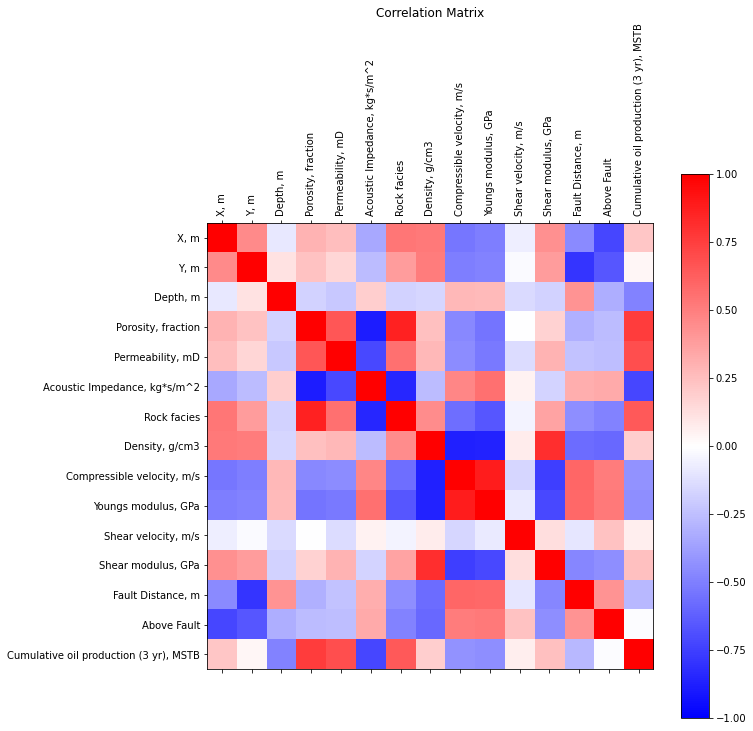

In [6]:
plot_corr(dfProdFinal)

#### Model Building

We needed to build out a function that could generate 100 versions of our model based on different bagged samples of our data. We utilized sklearn's train_test_split to grab 75% of the data at a time and applied xgboost's XGBRegressor algorithm to utilize gradient-boosted decision trees. 

In [7]:
def model_generator(features, target, seed):
    train_X, test_X, train_y, test_y = train_test_split(features, target, random_state=seed)
    model = xgb.XGBRegressor(random_state=1, n_jobs=-1)
    model.fit(train_X, train_y)
    return model

#### Build out Models

We create a list of models, which are generated with 100 different seeds of the test-train-split.

In [8]:
models = []
rng = np.random.RandomState(42)
for i in range(100):
    models.append(model_generator(X, y, rng.randint(0, 10000)))

#### Import Pre-production Well Data

Now that we have models built we need to apply them to our pre-production data. To do that, we must first import said data.

In [9]:
dfPreProd = pd.read_csv(r"./well_data/wellbore_data_preproduction_well.csv")
dfPreProdFinal = process_data(dfPreProd)

#### Apply Model to Pre-production Wells
We need the names for each of our realizations, as it has in the solutions, so first we create an array of column names with R1, R2, ..., R100
Then, we loop through our models and apply each one to our data to create 100 realizations each.

In [10]:
names = []
for i in range(100):
    names.append("R"+ str(i+1) + ", MSTB")
    
predictions = np.array([])
for model in models:
    predictions = np.append(predictions, np.array(model.predict(dfPreProdFinal)))
    
predictions = pd.DataFrame(predictions.reshape(100,10).T, columns=names)

#### Realization Histograms

Now, to check the viability of our realizations, we graphed them to ensure that they didn't seem strangely uniform or overly concentrated in any one spot. Additionally, we see that most of our graphs are normal or near-normal.

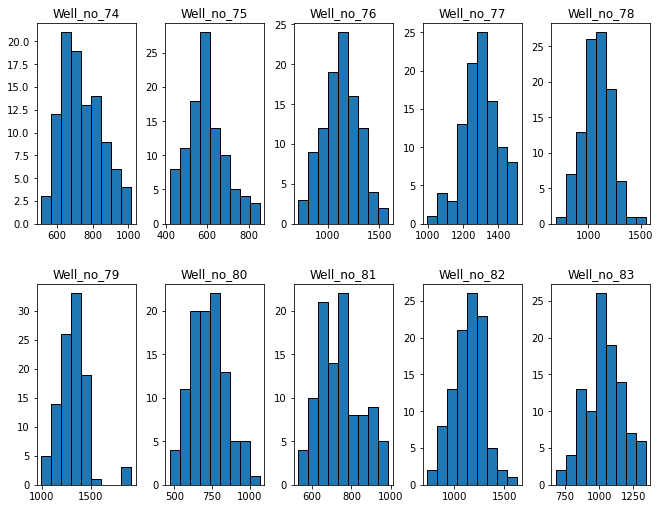

In [14]:
predictions["Well_ID"] = dfPreProdFinal.index
predictions = predictions.set_index("Well_ID")
predictions.T.hist(layout=(2,5), figsize=(11, 8.5), grid=False, bins=9, linewidth=1, edgecolor="black"); #Semicolon added to suppress extra Matplotlib output

#### Percentiles for Realizations

We then took the realizations and created a table of their P10, P50, and P90 values to give a better sense of bull and bear cases for each well.

In [12]:
p_values = pd.DataFrame([predictions.T.quantile(.10), predictions.T.quantile(.50), predictions.T.quantile(.90)])
p_values.index.names = ['Percentile']
p_values

Well_ID,Well_no_74,Well_no_75,Well_no_76,Well_no_77,Well_no_78,Well_no_79,Well_no_80,Well_no_81,Well_no_82,Well_no_83
Percentile,,,,,,,,,,
0.1,614.162024,481.249243,879.518994,1174.751147,908.311511,1171.224487,579.583148,619.234430,930.929675,851.354572
0.5,716.731506,590.163544,1136.709290,1294.682556,1092.323120,1329.355408,726.627594,735.697968,1148.454163,1041.290405
0.9,897.916888,712.961469,1346.238196,1427.862512,1243.321875,1468.173376,872.087866,912.029401,1314.268567,1214.107996


#### Finalize Results and Format Output
Finally, we create a "Prediction" for each well, based on the mean of the realizations for each respective well. Then, we reformat the DataFrame to match the formatting of the solutions by moving columns and setting the index properly. Finally, we use Pandas to export our realizations to a CSV

In [13]:
predictions["Prediction, MSTB"] = predictions.mean(axis=1)
predictions = predictions[["Prediction, MSTB"] + names]
predictions.to_csv(r".\final_solutions.csv")